In [2]:
# !pip install stellargraph[demos]

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

2022-02-09 19:08:03.796398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-09 19:08:03.796476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-09 19:08:08.071530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-09 19:08:08.071608: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-09 19:08:08.071658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-02-09 19:08:08.072169: I tensorflow/core/platform/cpu_fe

In [2]:
import datetime
import pandas as pd
#Put the file location
df = pd.read_csv('2020-12-23_all.csv')
# df2 = pd.read_csv('2020-12-24_all.csv')
# df = pd.concat([df1, df2])
#type casting
df.pm1_0 = df.pm1_0.astype(float)
df.pm2_5 = df.pm2_5.astype(float)
df.pm10 = df.pm10.astype(float)
df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
df.long= round(round(5*df.long.astype(float),2)/5.0,3)

df.dateTime = pd.to_datetime(df.dateTime)

print(len(df))
# Ensuring Delhi region and removing outliers from data
df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
#df = df[(df.humidity<=60)&(df.humidity>=7)]
print(len(df))

174400
174400


In [3]:
df

,Unnamed: 0,uid,dateTime,deviceId,lat,long,pm1_0,pm2_5,pm10
0,0,ab8afb71-2cd6-4b69-831b-8a557ac57f34,2020-12-23 00:00:00+05:30,00000000812d59d2,28.580,77.236,212.0,380.0,401.0
1,1,a119780e-f236-4231-8bf9-26ed6b680b6e,2020-12-23 00:00:01+05:30,100000003c7bc0b0,28.580,77.234,212.0,346.0,354.0
2,2,3b428d8b-12d3-4210-886b-7d3fde0267f9,2020-12-23 00:00:01+05:30,0000000029c36345,28.520,77.294,272.0,504.0,533.0
3,3,168e4a7f-2b7e-4996-bae8-9a247086d822,2020-12-23 00:00:01+05:30,00000000d4bc37f2,28.580,77.234,267.0,451.0,468.0
4,4,0cdc3253-c8ee-461b-a31b-dd65217d92fe,2020-12-23 00:00:03+05:30,00000000d4bc37f2,28.580,77.234,265.0,447.0,465.0
...,...,...,...,...,...,...,...,...,...
174395,174395,fc90f541-6c2a-4dc8-a150-579e3cddceb9,2020-12-23 23:59:51+05:30,10000000dc5bb76b,28.546,77.278,202.0,364.0,423.0
174396,174396,c2f4cef3-32ff-4292-9702-1893352bebe9,2020-12-23 23:59:53+05:30,100000003c7bc0b0,28.580,77.234,204.0,345.0,355.0
174397,174397,1e0c412e-e841-4b18-a8b4-bce0b92a108a,2020-12-23 23:59:54+05:30,10000000dc5bb76b,28.546,77.278,201.0,362.0,420.0
174398,174398,529d07ae-e245-40de-99ee-c9d2ea54dfbb,2020-12-23 23:59:56+05:30,100000003c7bc0b0,28.580,77.234,205.0,340.0,349.0


In [4]:
n_lat_grid_lines = 25
n_long_grid_lines = 25
n_grid_points = 26*26

In [5]:
# rounding @15min
df.dateTime = df.dateTime.dt.round('15min')

# only PM2_5
df = df[['dateTime','lat','long','pm2_5']]

# TODO: Add buffer and consider train-data for range
lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
long_range = {'min': df.long.min(), 'max': df.long.max()}

df['lat_grid'] = df.apply(lambda row: int(n_lat_grid_lines*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
df['long_grid'] = df.apply(lambda row: int(n_long_grid_lines*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
df['long_grid'] = df['long_grid'].astype(float).astype(int)
del df['lat']
del df['long']

# # TODO: use time as a feature as well
# # converting time to minutes and selecting a one hour slot for 9.00AM to 10.00AM
df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
# # dfHour = dfHour[(dfHour.dateTime>=hr_start) & (dfHour.dateTime<=hr_end)] 
# `
# print(df.head())

# # del dfHour['dateTime']

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [6]:
df

,dateTime,pm2_5,lat_grid,long_grid
0,0,380.0,12,14
1,0,346.0,12,14
2,0,504.0,4,21
3,0,451.0,12,14
4,0,447.0,12,14
...,...,...,...,...
174395,0,364.0,7,19
174396,0,345.0,12,14
174397,0,362.0,7,19
174398,0,340.0,12,14


In [7]:
df['grid'] = df['lat_grid']*26 + df['long_grid']
del df['lat_grid']
del df['long_grid']

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df

,dateTime,pm2_5,grid
0,0,380.0,326
1,0,346.0,326
2,0,504.0,125
3,0,451.0,326
4,0,447.0,326
...,...,...,...
174395,0,364.0,201
174396,0,345.0,326
174397,0,362.0,201
174398,0,340.0,326


In [9]:
sensor_dist_adj = np.zeros(shape=(26*26,26*26))
for i1 in range(26):
    for j1 in range(26):
        for i2 in range(26):
            for j2 in range(26):
                grid1 = i1*26 + j1
                grid2 = i2*26 + j2
                sensor_dist_adj[grid1][grid2] = (i1-i2)*(i1-i2)+ (j1-j2)*(j1-j2)

In [10]:
df = df.pivot_table(index='grid', columns='dateTime', aggfunc='mean')['pm2_5']
df

dateTime,0,15,30,45,60,75,90,105,120,135,...,1290,1305,1320,1335,1350,1365,1380,1395,1410,1425
grid,,,,,,,,,,,,,,,,,,,,,
22,403.769231,344.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,426.320442,NaN,393.458333,417.937198,441.428125,419.518519,413.039437,520.384615,404.933333,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,494.473684,449.406250,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,402.931034,NaN,342.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,382.000000,NaN,335.437500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = df.fillna(0)

In [12]:
df

dateTime,0,15,30,45,60,75,90,105,120,135,...,1290,1305,1320,1335,1350,1365,1380,1395,1410,1425
grid,,,,,,,,,,,,,,,,,,,,,
22,403.769231,344.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,426.320442,0.000000,393.458333,417.937198,441.428125,419.518519,413.039437,520.384615,404.933333,0.0
23,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
45,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
46,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
47,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,494.473684,449.406250,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,402.931034,0.000000,342.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
644,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,382.000000,0.000000,335.437500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [16]:
df.shape

(676, 96)

In [17]:
df = df.reindex(list(range(0, n_grid_points)),fill_value=0)
df

dateTime,0,15,30,45,60,75,90,105,120,135,...,1290,1305,1320,1335,1350,1365,1380,1395,1410,1425
grid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [19]:
train_rate = 0.8

In [20]:
train_data, test_data = train_test_split(df, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (676, 76)
Test data:  (676, 20)


In [21]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [22]:
train_scaled, test_scaled = scale_data(train_data, test_data)

In [23]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [24]:
seq_len = 4
pre_len = 1

In [25]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


(72, 676, 4)
(72, 676)
(16, 676, 4)
(16, 676)


In [26]:
from stellargraph.layer import GCN_LSTM

In [27]:
class MyModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(MyModel, self).__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
    def compute_loss(self, x, y, y_pred, sample_weight):
        mask = y[y != 0] = 1
        y_pred = y_pred.mul(mask)
        loss = tf.reduce_mean(tf.math.squared_difference(y_pred, y))
        loss += tf.add_n(self.losses)
        self.loss_tracker.update_state(loss)
        return loss

In [28]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


In [29]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [30]:
model = Model(inputs=x_input, outputs=x_output)

In [31]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [32]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 676, 4)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 676, 4, 1)        0         
                                                                 
 reshape (Reshape)           (None, 676, 4)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 676, 16)          457716    
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 676, 10)          457812    
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

In [34]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.025177041068673134 
Test loss: 0.027883093804121017


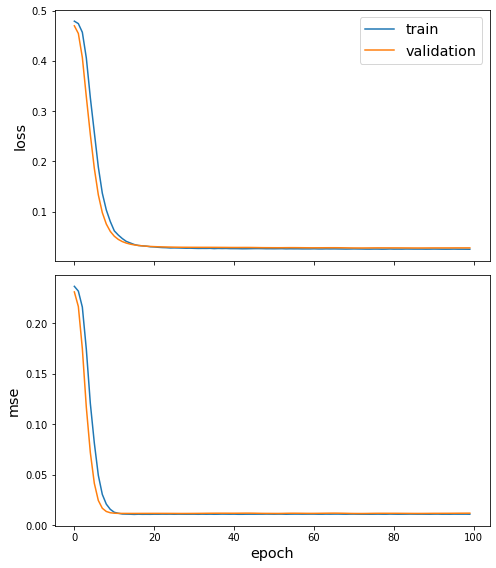

In [35]:
sg.utils.plot_history(history)

In [36]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

In [37]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [38]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

In [39]:
#Masked predicted values
mask_train = trainY[trainY != 0] = 1
mask_test = testY[testY != 0] = 1
train_rescpred = train_rescpred*(mask_train)
test_rescpred = test_rescpred*(mask_test)

In [40]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [41]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 0.4306465997360647
Total (ave) MAE for naive prediction: 0.0
Total (ave) MASE for per-segment NN/naive MAE: nan
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


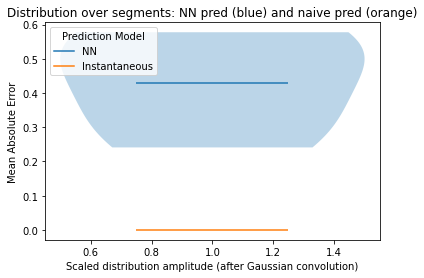

In [42]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

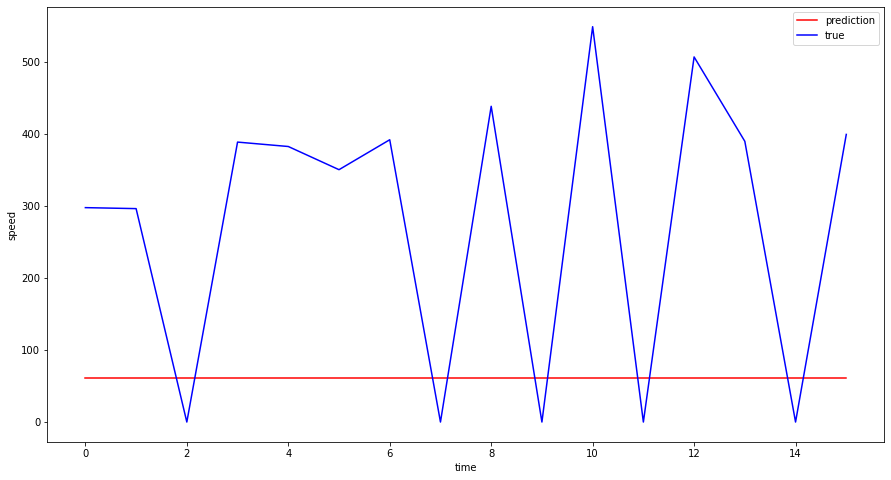

In [43]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

In [44]:
a_pred

array([60.624653, 60.624565, 60.6245  , 60.624477, 60.624454, 60.624454,
       60.624477, 60.624477, 60.624565, 60.6245  , 60.624565, 60.624588,
       60.624565, 60.62463 , 60.624653, 60.62474 ], dtype=float32)